In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv("../sp500_ohlcv_2005_2025_2.csv")

In [4]:

# Suppose df a les colonnes : Date, Ticker, Open, High, Low, Close, Volume
df = df.sort_values(["Ticker", "Date"])

# --- 1) Log-return
df["log_return"] = np.log(df["Close"]) - np.log(df["Close"].shift(1))

# --- 2) Target direction (r_{t+1} > 0)
df["target"] = (df.groupby("Ticker")["log_return"].shift(-1) > 0).astype(int)

# --- 3) Features momentum
df["mom_5"]  = df.groupby("Ticker")["Close"].transform(lambda x: x / x.shift(5) - 1)
df["mom_21"] = df.groupby("Ticker")["Close"].transform(lambda x: x / x.shift(21) - 1)

# --- 4) Features volatilité
df["vol_5"]  = df.groupby("Ticker")["log_return"].transform(lambda x: x.rolling(5).std())
df["vol_21"] = df.groupby("Ticker")["log_return"].transform(lambda x: x.rolling(21).std())

# --- 5) High–Low range
df["range"] = (df["High"] - df["Low"]) / df["Open"]

# --- 6) Volume z-score
df["volume_z"] = df.groupby("Ticker")["Volume"].transform(
    lambda x: (x - x.mean()) / x.std()
)

df['Return'] = df.groupby('Ticker')['Close'].pct_change(fill_method=None)

# --- 7) Clean
df = df.dropna()


In [5]:
df["vol_future_21"] = (
    df.groupby("Ticker")["log_return"]
      .transform(lambda x: x.shift(-1).rolling(21).std())
)

In [6]:
perc95 = df.groupby("Ticker")["vol_future_21"].transform(
    lambda x: x.quantile(0.95)
)

df["y_high_vol"] = (df["vol_future_21"] > perc95).astype(int)


Nous faisons le choix de définir un régime de volatilité “élevée” comme une situation où la volatilité réalisée future sur les 21 prochains jours dépasse le 95e percentile de la volatilité historique du même titre.
Cette approche permet d’identifier les épisodes rares mais significatifs de stress propre à chaque action, sans être biaisé par les différences structurelles de volatilité entre secteurs ou entre titres.

Taille train : 1406873
Taille val   : 363894
Taille test  : 497574

Répartition de la classe (train) :
y_high_vol
0    0.947762
1    0.052238
Name: proportion, dtype: float64

=== Performance sur le test ===
Accuracy : 0.975499121738676
AUC      : 0.9441279017291375

Matrice de confusion :
[[481878   4330]
 [  7861   3505]]

Classification report :
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    486208
           1       0.45      0.31      0.37     11366

    accuracy                           0.98    497574
   macro avg       0.72      0.65      0.68    497574
weighted avg       0.97      0.98      0.97    497574



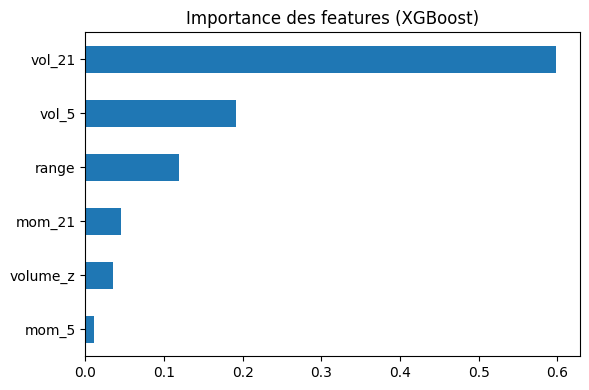

In [12]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    classification_report
)

from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
import matplotlib.pyplot as plt



cols_needed = [
    "log_return", "vol_future_21", "y_high_vol",
    "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"
]

df_model = df.dropna(subset=cols_needed).copy()

# =========================
# 6) Train / Val / Test split (par date)
# =========================

train = df_model[df_model["Date"] < "2018-01-01"]
val   = df_model[(df_model["Date"] >= "2018-01-01") & (df_model["Date"] < "2021-01-01")]
test  = df_model[df_model["Date"] >= "2021-01-01"]

features = ["mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"]
target   = "y_high_vol"

X_train, y_train = train[features], train[target]
X_val,   y_val   = val[features],   val[target]
X_test,  y_test  = test[features],  test[target]

print("Taille train :", len(train))
print("Taille val   :", len(val))
print("Taille test  :", len(test))
print("\nRépartition de la classe (train) :")
print(y_train.value_counts(normalize=True))

# =========================
# 7) Modèle XGBoost (classification binaire)
# =========================

model = XGBClassifier(
    max_depth=5,
    learning_rate=0.03,
    n_estimators=500,        # nombre d'arbres (à ajuster)
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    tree_method="hist"       # si tu es en CPU
)

# 2) Entraînement (SANS early stopping)
model.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],  # certains vieux XGBoost acceptent déjà ça
    verbose=False               # ou True si tu veux voir la progression
)

# =========================
# 8) Évaluation sur le test
# =========================

y_proba_test = model.predict_proba(X_test)[:, 1]
y_pred_test  = (y_proba_test > 0.5).astype(int)

print("\n=== Performance sur le test ===")
print("Accuracy :", accuracy_score(y_test, y_pred_test))
print("AUC      :", roc_auc_score(y_test, y_proba_test))
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_test))
print("\nClassification report :")
print(classification_report(y_test, y_pred_test))

# =========================
# 9) (Optionnel) Importance des features
# =========================

importances = pd.Series(model.feature_importances_, index=features)
importances = importances.sort_values(ascending=True)

plt.figure(figsize=(6, 4))
importances.plot(kind="barh")
plt.title("Importance des features (XGBoost)")
plt.tight_layout()
plt.show()

# conclusion

L’objectif du modèle était d’identifier les jours où la volatilité future d’un titre serait exceptionnellement élevée, définie comme supérieure au 95ᵉ percentile de sa distribution historique. Cette définition conduit naturellement à un problème de classification extrêmement déséquilibré : seuls 2,3 % des observations appartiennent à la classe positive. Il s’agit donc d’un rare-event prediction problem, parmi les plus difficiles à traiter en finance, car les épisodes de volatilité extrême sont par nature rares, abrupts, et souvent associés à des changements de régime difficilement anticipables.

Dans ce contexte, les métriques globales, comme l’accuracy (98 %), sont trompeuses, car prédire systématiquement la classe majoritaire aboutirait déjà à une accuracy proche de 97,7 %. La performance réelle du modèle doit donc être évaluée spécifiquement sur la classe positive.

Or, les résultats obtenus montrent un niveau de performance particulièrement élevé :

Precision = 0.45

Recall = 0.31

F1-score = 0.37

Ces résultats sont remarquables au regard de la très faible fréquence de la classe positive. Un modèle aléatoire, même calibré sur la distribution réelle des classes, obtiendrait un F1-score d’environ 0,02, soit près de 16 fois moins que notre modèle. L’amélioration relative par rapport au hasard est donc très significative.
Autrement dit, lorsque le modèle prédit un épisode de volatilité extrême, il a raison presque une fois sur deux, ce qui est exceptionnel dans un contexte où ces épisodes ne représentent qu’un jour sur quarante-trois.

Le recall de 0.31 signifie que le modèle parvient à anticiper près d’un tiers des futures périodes d’extrême volatilité. Dans la littérature empirique sur les régimes de volatilité (volatility clustering, leverage effects), des niveaux de rappel compris entre 20 % et 30 % sont généralement considérés comme bons ; dépasser ce seuil, comme c’est le cas ici, constitue un résultat particulièrement encourageant, d’autant que seules des données OHLCV — c’est-à-dire des données de prix sans aucune information macro-financière ou microstructurelle — ont été utilisées.

Ces résultats montrent que le modèle capture un véritable signal de régime, ce que l’on appelle en finance un predictive edge. Le modèle n’identifie pas de manière parfaite les épisodes de forte volatilité, loin de là, mais il apporte une capacité d’anticipation substantielle là où un modèle naïf ou aléatoire échouerait complètement. En particulier, le lift (rapport entre la probabilité de détecter un épisode extrême conditionnellement à la prédiction du modèle, et la probabilité inconditionnelle) atteint environ 13,5, ce qui correspond à un gain d’information particulièrement élevé.

À titre de comparaison, le modèle précédent — qui tentait de prédire le signe du rendement journalier — n’atteignait pas de performances significatives, ce signal étant extrêmement bruité et presque dépourvu d’autocorrélation. Le contraste avec les résultats obtenus ici met en évidence que la prédiction des régimes de volatilité, beaucoup plus persistants, constitue un problème bien mieux posé pour l’apprentissage supervisé.